In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer

plt.style.use('fivethirtyeight')

In [2]:
path = Path.home() / 'OneDrive - Seagroup/ai/kaggle_dataset/large_scale'

In [3]:
def select_n_filter_columns(df):
    return (
        df
        .select(pl.col('VendorID', 'tpep_pickup_datetime', 'total_amount', 'tolls_amount', 'payment_type', 'tip_amount', 'fare_amount', 'PULocationID'))
        .filter(pl.col('total_amount') > 100)
    )

def some_groupby_agg(df):
    return (
        df
        .groupby('VendorID', 'payment_type', 'PULocationID')
        .agg(pl.col('tip_amount').mean().alias('avg_tip_amount'))
    )

def some_window_func(df):
    return (
        df
        .select(
            pl.col('VendorID'),
            pl.col('payment_type'),
            pl.col('tpep_pickup_datetime'),
            pl.col('PULocationID'),
            pl.col('tip_amount'),
            pl.col('fare_amount').mean().over('payment_type').alias('mean_fare_amt_per_payment_type'),
        )
        .with_columns(
            pl.col('mean_fare_amt_per_payment_type').rank('dense', descending=True).over('VendorID').alias('dense_rank')
        )
    )

def join_on_a_few_column(df):
    unique_vendor_id_df = df.select('VendorID', 'payment_type', 'PULocationID').unique()
    return df.join(unique_vendor_id_df, on=['VendorID', 'payment_type', 'PULocationID'], how='left')

def write_to_csv(df):
    output_file_name = 'output.parquet'
    if type(df) == pl.LazyFrame:
        return df.collect().write_parquet(path / output_file_name, use_pyarrow=True)
    return df.write_parquet(path / output_file_name, use_pyarrow=True)

In [4]:
functions = [
    select_n_filter_columns, 
    some_window_func, 
    some_groupby_agg, 
    join_on_a_few_column,
]

result = []
file = path / '2021_Yellow_Taxi_Trip_Data.csv'
for f in tqdm(functions):
    # LazyFrame
    start = default_timer()
    df = pl.scan_csv(file).pipe(f).collect()
    durations = default_timer() - start
    result.append([durations, f.__name__, 'LazyFrame'])
    
    # DataFrame
    start = default_timer()
    df = pl.read_csv(file).pipe(f)
    durations = default_timer() - start
    result.append([durations, f.__name__, 'DataFrame'])

100%|██████████| 4/4 [00:26<00:00,  6.72s/it]


In [5]:
# LazyFrame
start = default_timer()
(
    pl.scan_csv(file)
    .pipe(select_n_filter_columns)
    .pipe(some_window_func)
    .pipe(some_groupby_agg)
    .pipe(join_on_a_few_column)
    .pipe(write_to_csv)
)
durations = default_timer() - start
result.append([durations, 'All functions at once', 'LazyFrame'])

# DataFrame
start = default_timer()
(
    pl.read_csv(file)
    .pipe(select_n_filter_columns)
    .pipe(some_window_func)
    .pipe(some_groupby_agg)
    .pipe(join_on_a_few_column)
    .pipe(write_to_csv)
)
durations = default_timer() - start
result.append([durations, 'All functions at once', 'DataFrame'])

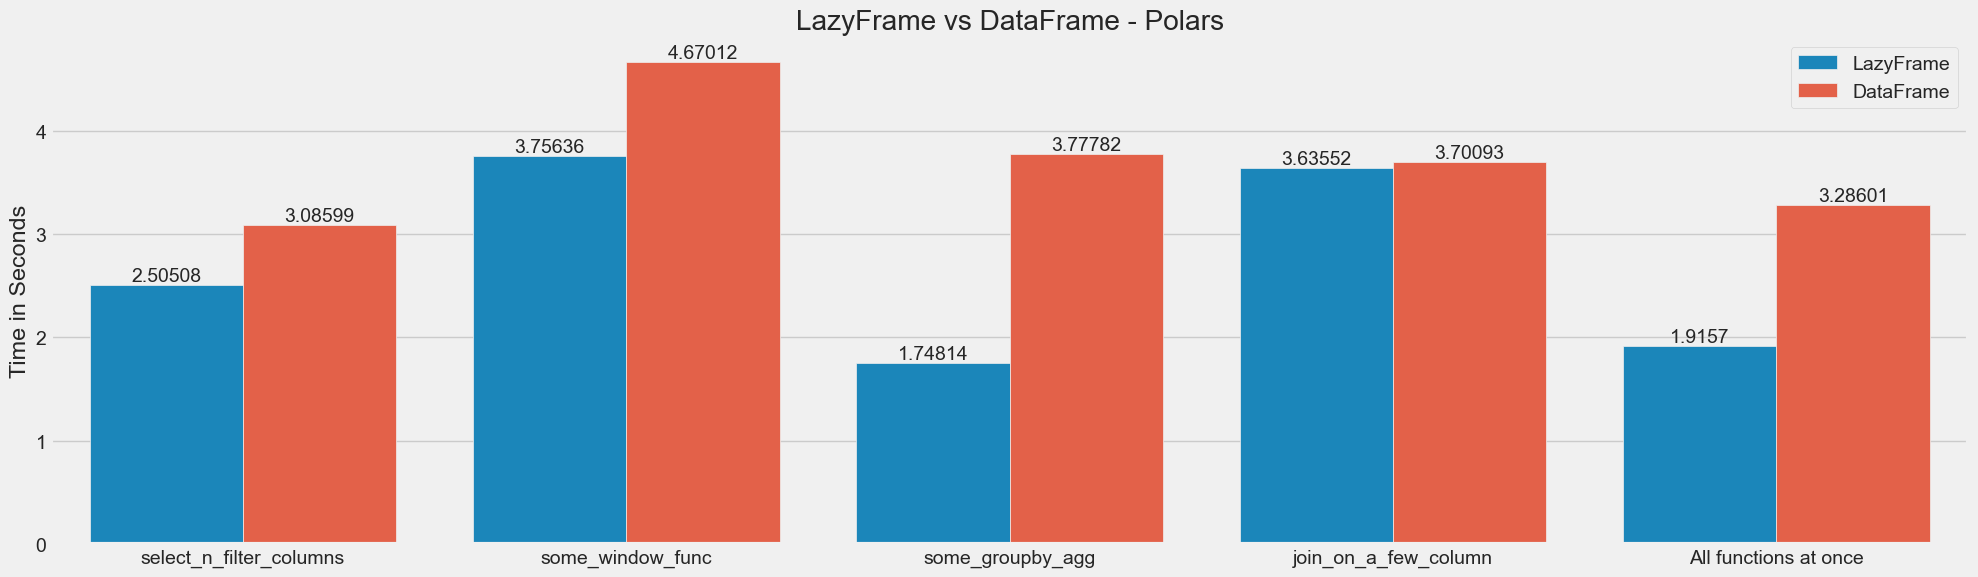

In [6]:
df = pl.DataFrame(result, schema=['time in seconds', 'func', 'type'])

plt.figure(figsize=(20, 6))
ax = sns.barplot(x=list(df['func']), y=list(df['time in seconds']), hue=list(df['type']), errorbar=None)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel='', ylabel='Time in Seconds')
plt.title('LazyFrame vs DataFrame - Polars')
plt.tight_layout()

In [6]:
lf = pl.LazyFrame(
    {
        "a": ["a", "b", "a", "b", "b", "c"],
        "b": [1, 2, 3, 4, 5, 6],
        "c": [6, 5, 4, 3, 2, 1],
    }
)
print(lf.groupby("a", maintain_order=True).agg(pl.all().sum()).sort("a").explain())

SORT BY [col("a")]
  AGGREGATE
  	[col("b").sum(), col("c").sum()] BY [col("a")] FROM
    DF ["a", "b", "c"]; PROJECT 3/3 COLUMNS; SELECTION: "None"


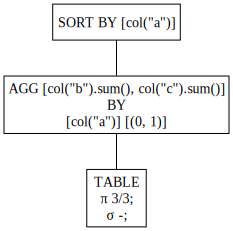

In [9]:
lf.groupby("a", maintain_order=True).agg(pl.all().sum()).sort("a").show_graph()